In [1]:
import som
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("MapaAutoorganizado").getOrCreate()
sc = spark.sparkContext

In [2]:
import numba
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np

@cuda.jit
def rand_weights(rng_states, d_weights):
    """
    Kernel para inicializar aleatoriamente la 'matriz' de pesos con valores 
    en el intervalo [0, 1) tomados de una distribución aleatoria
    :param rng_states Estados aleatorios
    :param d_weigths Vector de M * N * d valores que contendrá los pesos asociados a las neuronas
    """
    idx = cuda.grid(1)
    # Cogemos índices para pasar de array unidimensional a tridimensional
    n_rows, n_cols, d = d_weights.shape
    row = idx // (n_cols * d)
    col_d = idx % (n_cols * d)
    col = col_d // d
    i = col_d % d
    
    # Sacamos el aleatorio correspondiente
    if idx < d_weights.size:
        d_weights[row, col, i] = xoroshiro128p_uniform_float32(rng_states, idx)
    

In [3]:
"""
Implementación de un único kernel para ser ejecutado en cada partición del RDD.
"""
@cuda.jit
def som_iter(d_samples, d_weights, d_distances, d_nums, d_denums, sigma_squared):
    """
    Este kernel realiza el proceso de calcular las distancias euclídeas entre
    todas las muestras y los pesos de las neuronas. Encontrar la mejor BMU para
    una muestra y realizar el cálculo parcial de los pesos correspondientes.
    :param d_samples Conjunto de todas las muestras a evaluar.
    :param d_weights Array de filas * columnas * d valores con los pesos 
    asociados a cada una de las neuronas.
    :param d_distances Array de tamaño N * nneurons para almacenar
    las distancias
    :param d_nums Vector con los numeradores para el cálculo de la fórmula.
    :param d_denums Vector con los denominadores para el cálculo de la fórmula.
    :param sigma_squared Valor de sigma al cuadrado para el cáculo del vecindario.
    """
    # 0. Índices
    nrows, ncols, d = d_weights.shape
    nneurons = nrows * ncols
    
    
    sample_idx = cuda.blockIdx.x
    neuron_idx = cuda.threadIdx.x
    neuron_row = neuron_idx // ncols
    neuron_col = neuron_idx % ncols
    blockSize = cuda.blockDim.x
       
    # 1. Empezamos calculando la distancia euclídea de la muestra con las neuronas
    #    del bloque.
    shared_sample = cuda.shared.array(shape=0, dtype=numba.float32)
    
    # 1.a Cargamos la muestra del bloque en memoria compartida 
    for i in range(d // nneurons + 1):
        i_stride = i * nneurons
        my_pos = i_stride + cuda.threadIdx.x
        if my_pos < d:
            shared_sample[my_pos] = d_samples[sample_idx, my_pos]
            
    cuda.syncthreads()
    # 1.b Calculamos las distancias euclídeas que nos corresponden.
    if neuron_idx < nneurons:
        distance = 0.0
        for i in range(d):
            i_distance = shared_sample[i] - d_weights[neuron_row, neuron_col, i]
            distance += i_distance * i_distance
        d_distances[sample_idx, neuron_idx] = distance
    cuda.syncthreads()
    
    # 2. Realizamos la reducción
    # 2.a Declaramos la memoria compartida
    # (Pongo el tamaño máximo que puede usar, ya que sólo puedo indicar el
    # tamaño de uno de forma dinámica).
    shared_mem = cuda.shared.array(shape=1024, dtype=numba.float32)
    shared_idx = cuda.shared.array(shape=1024, dtype=numba.int32)
    
    # 2.b Inicializamos la memoria compartida
    #     rellanando con infinito a las posiciones que no utilizamos.
    if neuron_idx < nneurons:
        shared_mem[neuron_idx] = d_distances[sample_idx, neuron_idx]
    else:
        shared_mem[neuron_idx] = np.inf
        
    shared_idx[neuron_idx] = neuron_idx
    
    cuda.syncthreads()
    
    if blockSize >= 1024 and neuron_idx < 512:
        if shared_mem[neuron_idx + 512] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 512]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 512]
    cuda.syncthreads()
    
    if blockSize >= 512 and neuron_idx < 256:
        if shared_mem[neuron_idx + 256] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 256]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 256]
    cuda.syncthreads()
    
    if blockSize >= 256 and neuron_idx < 128:
        if shared_mem[neuron_idx + 128] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 128]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 128]
    cuda.syncthreads()
    
    if blockSize >= 128 and neuron_idx < 64:
        if shared_mem[neuron_idx + 64] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 64]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 64]
    cuda.syncthreads()
    
    if neuron_idx < 32:
        if shared_mem[neuron_idx + 32] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 32]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 32]
        if shared_mem[neuron_idx + 16] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 16]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 16]
        if shared_mem[neuron_idx + 8] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 8]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 8]
        if shared_mem[neuron_idx + 4] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 4]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 4]
        if shared_mem[neuron_idx + 2] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 2]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 2]
        if shared_mem[neuron_idx + 1] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 1]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 1]
    
    cuda.syncthreads()
    bmu = shared_idx[0]
    bmu_row = bmu // ncols
    bmu_col = bmu % ncols

    cuda.syncthreads()
    # 3. Realizamos la actualización de los pesos.
    if neuron_idx < nneurons:
        dist = (neuron_row - bmu_row) * (neuron_row - bmu_row) + \
               (neuron_col - bmu_col) * (neuron_col - bmu_col)
        # Si estamos dentro del rango de actualización.
        if dist <= sigma_squared:
            hck = math.exp(-dist/(2 * sigma_squared))
            # Guardamos sumatoria del denominador
            cuda.atomic.add(d_denums, neuron_row * ncols + neuron_col, hck)
            # Guardamos sumatoria del numerador
            for i in range(d):
                cuda.atomic.add(d_nums, neuron_row*ncols*d + neuron_col*d+i,
                                hck * shared_sample[i])


In [4]:
@cuda.jit
def finish_update(d_weights, partials, numParts):
    """
    Este kernel terminas las sumas parciales.
    Se ejecuta en un único nodo de Spark.
    
    :param weights Array de pesos de neuronas
    :param partials Array con sumas parciales
    :param numParts Número de resultados parciales a procesar.
    :param nrows Número de filas en la capa de salida.
    :param ncols Número de columnas en la capa de salida.
    :param d Dimensión de cada muestra.
    
    Estrucutra de bloques
    ---------------------
    Lanzamos nrows * ncols // tpb + 1 bloques.
    """
    idx = cuda.grid(1)
    nrows, ncols, d = d_weights.shape
    if idx < nrows * ncols:
        row = idx // ncols
        col = idx % ncols
        
        # a) Sumamos todos los parciales en el primer array
        numsize = nrows * ncols * d
        densize = nrows * ncols
        fullsize = numsize + densize
        for i in range(numParts - 1):
            # Suma de numeradores
            for k in range(d):
                partials[row * ncols * d + col * d + k] += partials[fullsize * i + row * ncols * d + col * d + k]
            # Suma de denominadores
            partials[numsize + row * ncols + col] += partials[fullsize * i + numsize + row * ncols + col]
            
    cuda.syncthreads()
    
    if idx < nrows * ncols:
        # b) Si no es 0 el denominador realizamos la división y cambiamos pesos actuales
        if partials[numsize + row * ncols + col] != 0:
            for k in range(d):
                d_weights[row, col, k] = partials[row*ncols*d + col*d +k] / \
                                         partials[numsize + row * ncols + col]

In [5]:
"""
Spark con GPU
"""
def gpu_work_iter(weights, sigma_squared):
    # Declarada función interna para devolverla y poder utilizar
    # múltiples parámetros al llamar a mapPartitions
    def _gpu_work(data):
        # 1. Procesamos el dataset
        inp = np.asarray(list(data), dtype=np.float32)
        rows, cols, d = weights.shape
        nneurons = rows * cols
        N = inp.shape[0]
    
        # 2. Pasamos los datos a las memorias del dispositivo
        d_samples = cuda.to_device(inp)
        d_weights = cuda.to_device(weights)
        d_distances = cuda.device_array((N, nneurons), dtype=np.float32)
        nums = np.zeros(rows * cols * d, np.float32)
        denums = np.zeros(rows * cols, np.float32)
        d_nums = cuda.to_device(nums)
        d_denums = cuda.to_device(denums)
        
        # 3. Tomamos el número de hebras por bloque
        if nneurons > 1024:
            raise Exception('Número de neuronas superior al límite')
        elif 512 < nneurons <= 1024:
            tpb = 1024
        elif 256 < nneurons <= 512:
            tpb = 512
        elif 128 < nneurons <= 256:
            tpb = 256
        elif 64 < nneurons <= 128:
            tpb = 128
        else:
            tpb = 64
            
        # 3. Lanzamos el kernel.
        sm_size = 4 * d # Memoria compartida para almacenar una muestra por bloque
        som_iter[N, tpb, 0, sm_size](d_samples, d_weights, d_distances, d_nums,
                                     d_denums, sigma_squared)
        
        return d_nums.copy_to_host(), d_denums.copy_to_host()
    return _gpu_work

In [6]:
def spark_gpu_batch_som(rdd_data, d, max_iters, rows, cols, smooth_iters=None, sigma_0=10, 
                          sigma_f=0.1, tau=400, seed=None, tpb=1024):
    
    # 1. Inicializamos pesos aleatorios
    d_weights = cuda.device_array((rows, cols ,d), np.float32)
    rng_states = create_xoroshiro128p_states(rows * cols * d, seed=seed)
    rand_weights[(d_weights.size) // tpb + 1, tpb](rng_states, d_weights)
     
    weights = d_weights.copy_to_host()
    # 2. Bucle del algoritmo
    for t in range(max_iters):
        # 2.a Actualizamos los parámetros de control si procede
        if smooth_iters is None or t < max_iters:
            sigma = sigma_0 * math.exp((-t/tau))
        else:
            sigma = sigma_f
            
        sigma_squared = sigma * sigma
        
        # 2.b Cada nodo del clúster de spark trabajará con un subconjunto
        # de las muestras del RDD para encontrar la BMU y realizar la suma
        # parcial de su ecucación de actualización de pesos
        out = rdd_data.mapPartitions(gpu_work_iter(weights, sigma_squared))
        
        # 2.c En un único nodo usamos la GPU para juntar todas las sumas parciales obtenidas
        #   y realizar la división
        out = out.collect()
        numParts = len(out) // 2

        partials = np.concatenate(out)
        finish_update[rows * cols // tpb + 1, tpb](weights, partials, numParts)
       
    return weights



In [7]:
"""
Ejemplo de las caras
"""
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
    
faces = fetch_olivetti_faces()['data']
rows = 5
cols = 6
d=faces.shape[1]
iters = 50
smooth_iters = 25
sigma_0 = 3
tau = 50
multiprocessors = 10
rdd_faces = sc.parallelize(faces).repartition(10).cache()
data = rdd_faces.collect()

In [8]:
inicio = time.time()
weights=spark_gpu_batch_som(rdd_faces, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

GPU
Tiempo ejecución (s) 281.0122787952423
Error de cuantificación: 6.556586524248123
Error topográfico: 0.0125


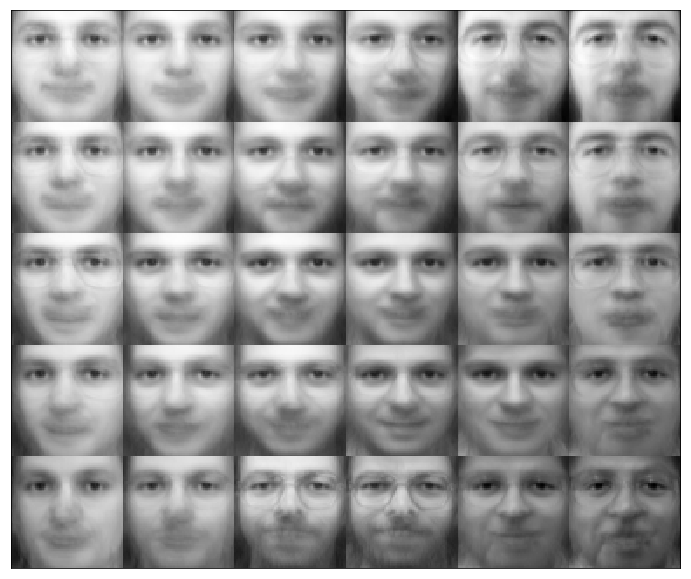

In [9]:
def pintar(texto, pesos):
    W = pesos
    pattern_length = faces.shape[1]
    pattern_width = pattern_height = int(np.sqrt(pattern_length))
    matrix_w = np.empty((rows * pattern_height, cols * pattern_width))


    for i in range(rows):
        for j in range(cols):
            matrix_w[i * pattern_height:i * pattern_height + pattern_height, 
    j * pattern_height:j * pattern_height + pattern_width] = W[i, j].reshape((pattern_height, pattern_width)) * 255.0
    fig, ax = plt.subplots(figsize=(12,12))

    ax.matshow(matrix_w.tolist(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    print(texto)
    print('Tiempo ejecución (s)', fin - inicio)
    print('Error de cuantificación:', som.quantification_error(faces, weights) )
    print('Error topográfico:', som.topography_error(faces, weights))
    plt.show()
pintar('GPU', weights)

In [10]:
inicio = time.time()
weights = som.spark_cpu_batch_som(rdd_faces, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

CPU
Tiempo ejecución (s) 203.08935570716858
Error de cuantificación: 6.571182821291246
Error topográfico: 0.0325


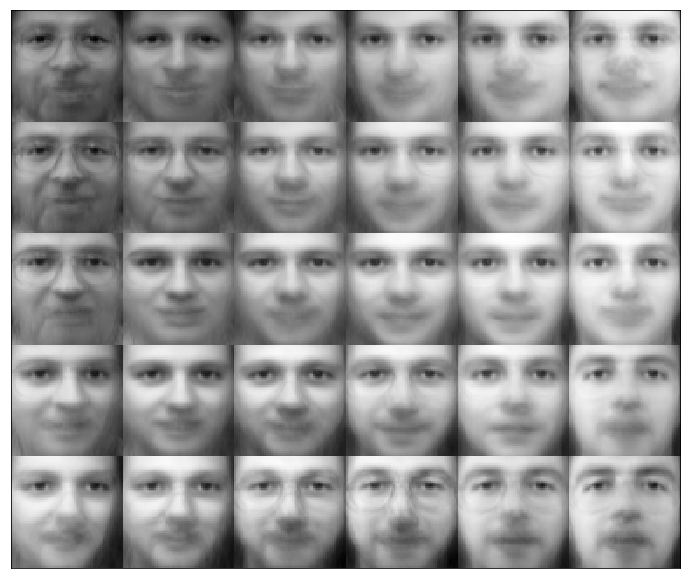

In [11]:
pintar('CPU', weights)

In [13]:
"""
Experimento con SUSY.
"""
d = 18
rows = 8
cols = 7
tau = 10
smooth_iters = 5
max_iters = 10
sigma_0 = 4

from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.sql import Row

multiprocessors = 10
rdd = sc.textFile('../datasets/SUSY.csv').repartition(multiprocessors)
rdd = rdd.map(lambda line: line.split(','))
rdd = rdd.map(lambda line: Row(features=DenseVector(line[1:])))
df = rdd.toDF()
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(df)
normalized_df = scalerModel.transform(df)
rdd = normalized_df.rdd
rdd = rdd.map(lambda line: np.float32(line.scaledFeatures))

In [32]:
def subsample_and_repeat(sub_percent, rdd, repeat=5):
    subrdd = rdd.sample(True, sub_percent, seed=7).cache()
    a = subrdd.take(1)
    for my_iter in range(repeat):
        print('REPETICIÓN', my_iter)
        inicio = time.time()
        cpu_weights=som.spark_cpu_batch_som(subrdd, d, max_iters, rows, cols,  smooth_iters, sigma_0, 0.1, tau, seed=my_iter)
        fin = time.time()
        print('TIEMPO CPU', fin - inicio)
        inicio = time.time()
        weights=spark_gpu_batch_som(subrdd, d, max_iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=my_iter)
        fin = time.time()
        print('TIEMPO GPU', fin - inicio)
    subrdd.unpersist()

In [45]:
subsample_and_repeat(0.1, rdd)

REPETICIÓN 0
TIEMPO CPU 311.9454336166382
TIEMPO GPU 61.12499809265137
REPETICIÓN 1
TIEMPO CPU 230.31099128723145
TIEMPO GPU 56.81826901435852
REPETICIÓN 2
TIEMPO CPU 230.9339165687561
TIEMPO GPU 56.65690207481384
REPETICIÓN 3
TIEMPO CPU 230.83588933944702
TIEMPO GPU 57.69595980644226
REPETICIÓN 4
TIEMPO CPU 232.28378748893738
TIEMPO GPU 56.78418707847595


In [34]:
subsample_and_repeat(0.2, rdd)

REPETICIÓN 0
TIEMPO CPU 477.870573759079
TIEMPO GPU 57.98743391036987
REPETICIÓN 1
TIEMPO CPU 428.47241830825806
TIEMPO GPU 58.247504472732544
REPETICIÓN 2
TIEMPO CPU 424.0144865512848
TIEMPO GPU 59.239057540893555
REPETICIÓN 3
TIEMPO CPU 425.7604811191559
TIEMPO GPU 58.77162456512451
REPETICIÓN 4
TIEMPO CPU 426.51278162002563
TIEMPO GPU 58.6843843460083


In [35]:
subsample_and_repeat(0.3, rdd)

REPETICIÓN 0
TIEMPO CPU 675.4577059745789
TIEMPO GPU 59.29868197441101
REPETICIÓN 1
TIEMPO CPU 611.0369417667389
TIEMPO GPU 59.229564905166626
REPETICIÓN 2
TIEMPO CPU 629.5427460670471
TIEMPO GPU 59.443618059158325
REPETICIÓN 3
TIEMPO CPU 610.7269601821899
TIEMPO GPU 59.667152404785156
REPETICIÓN 4
TIEMPO CPU 621.8638815879822
TIEMPO GPU 67.2864682674408


In [36]:
subsample_and_repeat(0.4, rdd)

REPETICIÓN 0
TIEMPO CPU 884.0172743797302
TIEMPO GPU 61.107426166534424
REPETICIÓN 1
TIEMPO CPU 822.0021846294403
TIEMPO GPU 67.31740236282349
REPETICIÓN 2
TIEMPO CPU 825.7120983600616
TIEMPO GPU 60.959519386291504
REPETICIÓN 3
TIEMPO CPU 819.2540249824524
TIEMPO GPU 61.241209268569946
REPETICIÓN 4
TIEMPO CPU 823.2226598262787
TIEMPO GPU 61.40292024612427


In [37]:
subsample_and_repeat(0.5, rdd)

REPETICIÓN 0
TIEMPO CPU 1073.574865102768
TIEMPO GPU 64.10907745361328
REPETICIÓN 1
TIEMPO CPU 1001.5567107200623
TIEMPO GPU 68.71183443069458
REPETICIÓN 2
TIEMPO CPU 1012.3097813129425
TIEMPO GPU 62.22735786437988
REPETICIÓN 3
TIEMPO CPU 1029.7548236846924
TIEMPO GPU 62.13866686820984
REPETICIÓN 4
TIEMPO CPU 1026.1754457950592
TIEMPO GPU 71.81369471549988


In [38]:
subsample_and_repeat(0.6, rdd)

REPETICIÓN 0
TIEMPO CPU 1289.5344324111938
TIEMPO GPU 67.03625917434692
REPETICIÓN 1
TIEMPO CPU 1192.4951195716858
TIEMPO GPU 63.12589240074158
REPETICIÓN 2
TIEMPO CPU 1215.032455921173
TIEMPO GPU 71.00160264968872
REPETICIÓN 3
TIEMPO CPU 1237.90021443367
TIEMPO GPU 71.56066632270813
REPETICIÓN 4
TIEMPO CPU 1203.0439476966858
TIEMPO GPU 65.2864441871643


In [39]:
subsample_and_repeat(0.7, rdd)

REPETICIÓN 0
TIEMPO CPU 1479.847000360489
TIEMPO GPU 64.70413279533386
REPETICIÓN 1
TIEMPO CPU 1396.4773638248444
TIEMPO GPU 64.88685727119446
REPETICIÓN 2
TIEMPO CPU 1391.7636227607727
TIEMPO GPU 67.31108498573303
REPETICIÓN 3
TIEMPO CPU 1410.108733177185
TIEMPO GPU 71.76965951919556
REPETICIÓN 4
TIEMPO CPU 1394.0187084674835
TIEMPO GPU 64.56651067733765


In [40]:
subsample_and_repeat(0.8, rdd)

REPETICIÓN 0
TIEMPO CPU 1655.9664931297302
TIEMPO GPU 65.66099500656128
REPETICIÓN 1
TIEMPO CPU 1636.6946482658386
TIEMPO GPU 72.31240272521973
REPETICIÓN 2
TIEMPO CPU 1606.9916543960571
TIEMPO GPU 65.94269609451294
REPETICIÓN 3
TIEMPO CPU 1609.6571338176727
TIEMPO GPU 66.1844596862793
REPETICIÓN 4
TIEMPO CPU 1613.3835670948029
TIEMPO GPU 66.107990026474


In [41]:
subsample_and_repeat(0.9, rdd)

REPETICIÓN 0
TIEMPO CPU 1861.561919927597
TIEMPO GPU 70.09243965148926
REPETICIÓN 1
TIEMPO CPU 1782.3216845989227
TIEMPO GPU 73.0834174156189
REPETICIÓN 2
TIEMPO CPU 1783.0005617141724
TIEMPO GPU 67.21117568016052
REPETICIÓN 3
TIEMPO CPU 1800.896877527237
TIEMPO GPU 66.79486608505249
REPETICIÓN 4
TIEMPO CPU 1787.793312549591
TIEMPO GPU 66.73649621009827


In [42]:
subsample_and_repeat(1.0, rdd)

REPETICIÓN 0
TIEMPO CPU 2067.6030445098877
TIEMPO GPU 68.14827156066895
REPETICIÓN 1
TIEMPO CPU 1990.5172321796417
TIEMPO GPU 68.19507813453674
REPETICIÓN 2
TIEMPO CPU 1986.354835987091
TIEMPO GPU 73.55967164039612
REPETICIÓN 3
TIEMPO CPU 1988.1593148708344
TIEMPO GPU 73.60444808006287
REPETICIÓN 4
TIEMPO CPU 2005.4214770793915
TIEMPO GPU 73.82634019851685
